# Attempt to extract bedloads from seismic and river discharge time series

Originally by Brad Lipovsky (bpl7@uw.edu), modified by Marine Denolle (mdenolle@uw.edu) and Claude Sonnet.
Modified 
This notebook :
- pulls a metadata of pairs of seismic stations and river gages
- pulls the river gage data from USGS
- download seismic power from from UW/CC stations with obspy, exclude earthquake signals.
- 


It then computes a simple **band-limited RMS proxy** (a stand-in for “river rumble”/bedload-related noise used in Roth/Gimbert-style workflows) and compares it to gauge stage/discharge to look for **lag and hysteresis** (proxy persisting after gauges recede).


---

## Model being tested (what we fit)

### Observations

- Seismic “river rumble” proxy: $P(t)$, computed from band-limited seismic data in sliding windows (either RMS or PSD-integrated bandpower; optionally combined across components by RSS).
- River forcing proxy from USGS gage: $Q(t)$ (typically discharge, else stage).

### 1) Constant-lag alignment

We assume the seismic proxy responds to discharge with a **constant time lag** $\tau$ (hours):
$$
P(t) \;\text{is most directly related to}\; Q(t-\tau).
$$

In code we implement this by shifting the gage timestamps forward by $\tau$ and then correlating at common times:
$$
Q_{\tau}(t) = Q(t+\tau)\quad\Rightarrow\quad \text{compare } P(t)\;\text{with }Q_{\tau}(t).
$$

Interpretation:
- $\tau>0$: seismic proxy **lags** discharge (rumble persists after the flow rise).
- $\tau<0$: seismic proxy **leads** discharge (usually not expected physically; can indicate timing/metadata issues).

We select $\tau$ by scanning a grid (e.g., $|\tau|\le 24\,$h) and maximizing the correlation between transformed series (often in log space).

### 2) Log–log scaling (amplitude relation)

Once aligned, we often test a simple power-law scaling between proxy amplitude and discharge:
$$
P(t) \approx C\,Q(t-\tau)^{\beta}
$$
Equivalently in base-10 log space (what we correlate/fit most often):
$$
\log_{10} P(t) = a + \beta\,\log_{10} Q(t-\tau) + \varepsilon(t),\qquad a=\log_{10} C.
$$

Parameter meaning:
- $\tau$: constant lag between hydraulics and seismic proxy.
- $C$ (or $a$): overall gain (site/path/instrument/geometry).
- $\beta$: sensitivity exponent (how strongly proxy grows with discharge).
- $\varepsilon(t)$: residual variability (e.g., sediment supply changes, bed state, non-fluvial noise).

### 3) Two-band “flow vs bedload” diagnostics (used later)

We compute two proxy time series from different frequency bands:
- $P_{\mathrm{flow}}(t)$: lower-frequency band (more hydraulic control).
- $P_{\mathrm{bed}}(t)$: higher-frequency band (more bedload/impacts).

After applying the chosen $\tau$, we use two simple derived measures (on high-flow times, $Q\ge Q_c$):

**(a) Bedload residual after removing discharge trend**
$$
\log_{10} P_{\mathrm{bed}}(t) = m\,\log_{10} Q(t-\tau) + b + r(t)
$$
where $r(t)$ (the residual) is interpreted as a bed/supply-related modulation beyond hydraulics.

**(b) Band ratio (relative strengthening of bedload band)**
$$
R(t) = \log_{10}\!\left(\frac{P_{\mathrm{bed}}(t)}{P_{\mathrm{flow}}(t)}\right)=\log_{10}P_{\mathrm{bed}}(t)-\log_{10}P_{\mathrm{flow}}(t).
$$

Here $Q_c$ is an effective transport threshold (in this notebook approximated by a discharge percentile).


In [8]:
# If you don't have these yet:
# !pip install obspy pandas numpy scipy matplotlib requests lxml

import re
import sys
import importlib
import inspect
from pathlib import Path

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from zoneinfo import ZoneInfo

from obspy import UTCDateTime, Stream
from obspy.clients.fdsn import Client
from obspy.signal.filter import bandpass

# Make sure we can import notebooks/utils.py whether the notebook cwd is repo root or notebooks/
_cwd = Path.cwd()
_candidates = [_cwd, _cwd / "notebooks", _cwd.parent, _cwd.parent / "notebooks"]
for _d in _candidates:
    if (_d / "utils.py").exists():
        sys.path.insert(0, str(_d))
        break

# Import + reload utils, then *rebind* the helpers so signatures stay in sync
import utils as _utils
_utils = importlib.reload(_utils)
print("utils loaded from:", getattr(_utils, "__file__", "<unknown>"))
print("plot_proxy_and_gauge signature:", inspect.signature(_utils.plot_proxy_and_gauge))

# Re-export helpers into the notebook namespace
load_station_gage_pairs = _utils.load_station_gage_pairs
fetch_usgs_gage_timeseries = _utils.fetch_usgs_gage_timeseries
download_streams = _utils.download_streams
fetch_usgs_event_times = _utils.fetch_usgs_event_times
stream_to_proxy_timeseries = _utils.stream_to_proxy_timeseries
estimate_constant_lag_seconds = _utils.estimate_constant_lag_seconds
plot_proxy_and_gauge = _utils.plot_proxy_and_gauge
hysteresis_plot = _utils.hysteresis_plot
band_sweep = _utils.band_sweep

plt.rcParams["figure.dpi"] = 120


utils loaded from: /Users/marinedenolle/GitHub/seis-hydro-2-sed/notebooks/utils.py
plot_proxy_and_gauge signature: (proxy: 'pd.Series | pd.DataFrame', gauge_df: 'pd.DataFrame | pd.Series', title: 'str' = '', save_dir: 'str | Path | None' = None, filename: 'str | None' = None, dpi: 'int' = 200, gauge_col: 'str | None' = None) -> 'None'


In [38]:
from pathlib import Path

# Cache/data products (waveforms, metadata, results) live under ./data
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

# All figures are saved under ./figures (repo root)
FIG_DIR = Path("figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

## Configuration

Adjust the time window and frequency bands here. The default window is **Dec 7–14, 2025 (UTC)** to bracket the main atmospheric-river impacts and any post-peak rumble.

Tip: Start with a broad band like **5–30 Hz**, then sweep bands (e.g. 2–8, 5–15, 10–30) to find where the river signal is clearest at each station.


In [10]:
# --- Time window (UTC) ---
START = UTCDateTime("2025-12-01T00:00:00")
END   = UTCDateTime("2025-12-24T00:00:00")

# --- Metadata source (station ↔ USGS gage pairs) ---
METADATA_CSV_URL = (
    "https://raw.githubusercontent.com/gaia-hazlab/gaia-data-downloaders/main/"
    "stations_by_basin_with_gages.csv"
 )

# Filter down the metadata to a manageable subset (optional)
NETWORK_FILTER = ["CC"]                 # seismic networks to include
BASIN_FILTER = None              # e.g. ["Cowlitz"], ["Puyallup"], or None for all
MAX_PAIRS = None                         # limit for quick iteration; set None to run all pairs

# Focus on a single station (set None to run all loaded pairs)
FOCUS_SEIS_KEY = "CC.PR03"

# --- Proxy definition (science-plan aligned) ---
PROXY_METHOD = "bandpower"              # "bandpower" (PSD-integrated) or "rms"
USE_RSS = True                           # True: combine Z/N/E as RSS; False: Z-only preferred
COMPONENTS = ("Z", "N", "E")

# --- Default band + windowing (10 min window, 5 min step) ---
FMIN, FMAX = 5.0, 30.0      # Hz
WIN_SECONDS = 600
STEP_SECONDS = 300

# Candidate bands for CC.PR01 band exploration (edit as needed)
FLOW_BANDS = [(0.5, 2.0), (1.0, 5.0), (2.0, 8.0)]
BEDLOAD_BANDS = [(5.0, 15.0), (5.0, 20.0), (10.0, 30.0)]

# --- Constant lag scan settings (proxy vs discharge) ---
LAG_MAX_HOURS = 24
LAG_STEP_MINUTES = 10

# --- Impulse clipping (STA/LTA) ---
# If any impulsive transient is detected within a UTC day, we clip the *entire day's*
# waveform to ±(CLIP_SIGMA * std_of_that_day).
CLIP_IMPULSES = True
STA_SECONDS = 1.0
LTA_SECONDS = 20.0
TRIGGER_ON = 3.5
TRIGGER_OFF = 1.0
CLIP_SIGMA = 2.0
CLIP_MODE = "symmetric"   # "symmetric" (±thr) or "upper" (+thr only)

# --- Earthquake exclusion (USGS catalog masking) ---
EXCLUDE_EARTHQUAKES = True
EQ_MIN_MAG = 3.5
EQ_MAXRADIUS_KM = 500
EQ_BUFFER_SECONDS = 20 * 60  # drop proxy windows within +/- this of origin time

# --- Extra outlier removal on proxy series (post-processing) ---
# This catches isolated spikes that slip through EQ masking/impulse clipping.
DESPIKE_PROXY = True
DESPIKE_WINDOW = "6H"          # rolling window for median/MAD (e.g., "2H", "6H")
DESPIKE_Z = 8.0                # robust z threshold; increase to be less aggressive
DESPIKE_MIN_PERIODS = 10
DESPIKE_FILL = "interpolate"          # "none" leaves NaNs; "interpolate" fills gaps

# --- Output choice for response removal ---
OUTPUT = "velocity"  # "acceleration" or "velocity"

# --- FDSN request controls (used in multiple sections) ---
# Channel/location wildcards can be tuned after the preview download cell.
CHANNEL = "BH?"
LOCATION = "*"

# --- Local waveform cache ---
# Ensure DATA_DIR exists even if this cell is run out of order.
if "DATA_DIR" not in globals():
    from pathlib import Path
    DATA_DIR = Path("data")
    DATA_DIR.mkdir(exist_ok=True)
FDSN_CACHE_DIR = DATA_DIR / "fdsn_cache"
FDSN_CACHE_DIR.mkdir(parents=True, exist_ok=True)

## 1) Load station↔gage metadata + download USGS gauge data

We’ll use the GAIA HazLab metadata table to define which seismic stations pair with which USGS gages:
- metadata CSV: `stations_by_basin_with_gages.csv`
- key columns: `network`, `station`, `gage_id`, `basin_name`, `latitude`, `longitude`

Some seismic stations appear with **multiple candidate gages** in the GAIA table.
We automatically choose the **closest gage** for each station by:
1) querying USGS site metadata for each gage to get its lat/lon,
2) computing station↔gage great-circle distance,
3) keeping the smallest-distance gage per station.

Gauge time series are then loaded from the GAIA pre-generated gage exports (with optional NWIS fallback), and cached under `data/` so re-running is fast.

In [11]:
# (Re-)import in case you run this cell standalone
from utils import load_station_gage_pairs, fetch_usgs_gage_timeseries

# --- Load metadata pairs and derive station/gage lists ---
pairs_df = load_station_gage_pairs(
    METADATA_CSV_URL,
    data_dir=DATA_DIR,
    network_filter=NETWORK_FILTER,
    basin_filter=BASIN_FILTER,
    max_pairs=MAX_PAIRS,
    use_cache=True,
    choose_closest_gage=True,
 )

if FOCUS_SEIS_KEY is not None:
    pairs_df = pairs_df[pairs_df["seis_key"] == FOCUS_SEIS_KEY].reset_index(drop=True)

print(f"Loaded {len(pairs_df)} station↔gage pairs")
display(pairs_df[["seis_key", "gage_id", "gage_distance_km", "basin_name"]].head())

SEIS_REQUESTS = list(zip(pairs_df["network"].tolist(), pairs_df["station"].tolist()))
SEIS_KEYS = pairs_df["seis_key"].tolist()
GAUGE_IDS = sorted(pairs_df["gage_id"].unique().tolist())
PAIRINGS = dict(zip(pairs_df["seis_key"].tolist(), pairs_df["gage_id"].tolist()))

# Distance (km) between each station and its chosen closest gage (if available)
DIST_KM = (
    dict(zip(pairs_df["seis_key"], pairs_df["gage_distance_km"]))
    if "gage_distance_km" in pairs_df.columns
    else {}
 )

# Station metadata for later (e.g., earthquake search radius)
STATION_META = {
    row.seis_key: {
        "network": row.network,
        "station": row.station,
        "latitude": float(row.latitude) if not pd.isna(row.latitude) else None,
        "longitude": float(row.longitude) if not pd.isna(row.longitude) else None,
        "basin_name": row.basin_name if hasattr(row, "basin_name") else None,
        "gage_id": row.gage_id,
        "gage_distance_km": float(row.gage_distance_km) if hasattr(row, "gage_distance_km") and not pd.isna(row.gage_distance_km) else None,
        "gage_latitude": float(row.gage_latitude) if hasattr(row, "gage_latitude") and not pd.isna(row.gage_latitude) else None,
        "gage_longitude": float(row.gage_longitude) if hasattr(row, "gage_longitude") and not pd.isna(row.gage_longitude) else None,
        "gage_name": row.gage_name if hasattr(row, "gage_name") else None,
    }
    for row in pairs_df.itertuples(index=False)
}

# --- Fetch all gauges for the time window ---
# Uses GAIA pre-generated gage exports on GitHub by default, with NWIS fallback
gauges = {}
for gid in GAUGE_IDS:
    print(f"Loading USGS site {gid} (cached if available)...")
    try:
        gauges[gid] = fetch_usgs_gage_timeseries(gid, START, END, data_dir=DATA_DIR, use_cache=True)
    except Exception as e:
        print(f"  Failed site {gid}: {e}")

{k: (v.index.min(), v.index.max(), len(v)) for k, v in gauges.items()}

Loaded 1 station↔gage pairs


,seis_key,gage_id,gage_distance_km,basin_name
0,CC.PR03,12092000,0.186398,Puyallup


Loading USGS site 12092000 (cached if available)...


{'12092000': (Timestamp('2025-12-01 00:00:00+0000', tz='UTC'),
  Timestamp('2025-12-15 21:15:00+0000', tz='UTC'),
  1430)}

In [12]:
STATION_META

{'CC.PR03': {'network': 'CC',
  'station': 'PR03',
  'latitude': 46.903433,
  'longitude': -122.032691,
  'basin_name': 'Puyallup',
  'gage_id': '12092000',
  'gage_distance_km': 0.18639766622464632,
  'gage_latitude': 46.9037164,
  'gage_longitude': -122.0351092,
  'gage_name': 'PUYALLUP RIVER NEAR ELECTRON, WA'}}

## 2) Download seismic data  

Because channel naming varies (especially for strong-motion installations), we:
1. query station metadata (`get_stations(level="channel")`),
2. pick “best” channels by **preferred prefix** (HN/BN/EH/HH) and **highest sample rate**,
3. fetch waveforms for those channels with attached response.

If the first candidate fails, we try a few more.


In [13]:
# Section 2: download a short waveform preview (for channels/SR), not the full multi-week record
import pickle
from utils import download_streams

# Full 2-week 100 Hz 3C waveforms can be multiple GB; instead we download a short preview here.
PREVIEW_HOURS = 2
preview_end = min(START + PREVIEW_HOURS * 3600, END)

suffix = FOCUS_SEIS_KEY.replace(".", "_") if FOCUS_SEIS_KEY else "all"
STREAMS_PREVIEW_FILE = DATA_DIR / f"streams_preview_{suffix}.pkl"

try:
    if STREAMS_PREVIEW_FILE.exists():
        print(f"Loading cached preview streams from {STREAMS_PREVIEW_FILE}...")
        with open(STREAMS_PREVIEW_FILE, "rb") as f:
            streams_preview = pickle.load(f)
    else:
        raise FileNotFoundError
except Exception as e:
    print(f"Preview cache load failed ({e}). Downloading preview streams...")
    streams_preview = download_streams(SEIS_REQUESTS, START, preview_end, client_name="IRIS")
    with open(STREAMS_PREVIEW_FILE, "wb") as f:
        pickle.dump(streams_preview, f)

print(f"Preview streams: {len(streams_preview)}")
for k, st in streams_preview.items():
    chans = sorted({tr.stats.channel for tr in st})
    srs = sorted({float(tr.stats.sampling_rate) for tr in st})
    print(k, "channels:", chans, "sampling_rates:", srs)

Preview cache load failed (). Downloading preview streams...
Preview streams: 1
CC.PR03 channels: ['BHE', 'BHN', 'BHZ'] sampling_rates: [50.0]


## 3) Preprocess and compute a “river rumble” proxy

Workflow:
1. Merge and trim to requested time range.
2. Detrend, taper.
3. Remove instrument response to **acceleration** (m/s²).
4. Optionally integrate to **velocity** (m/s).
5. Combine components by root-sum-square (RSS).
6. Bandpass filter (e.g., 5–30 Hz).
7. Compute moving-window **RMS**.

Output: a pandas Series indexed by UTC timestamps.


In [15]:
# Section 3: compute band proxy series by downloading waveforms in full UTC days
# (cached as daily MiniSEED). Broadband proxy dict is intentionally removed.
# Also builds a single tidy dataframe `band_proxy_df` for downstream work.

from utils import fetch_usgs_event_times, compute_proxy_from_fdsn

# If an old kernel state still has a broadband `proxies` dict, remove it to avoid confusion.
if "proxies" in globals():
    del proxies

band_proxies: dict[str, dict[tuple[float, float], pd.Series]] = {}
event_cache: dict[str, pd.DatetimeIndex] = {}

bands = FLOW_BANDS + BEDLOAD_BANDS
combine_mode = "rss" if USE_RSS else "z"

# Uses CHANNEL/LOCATION/FDSN_CACHE_DIR from the Configuration section.
for sta_key in SEIS_KEYS:
    net, sta = sta_key.split(".", 1)
    print(f"Processing station {sta_key} (daily FDSN download + cache) ...")

    # Fetch nearby event times once per station (optional)
    ev_times = None
    if EXCLUDE_EARTHQUAKES:
        meta = STATION_META.get(sta_key, {})
        lat = meta.get("latitude")
        lon = meta.get("longitude")
        if lat is not None and lon is not None:
            if sta_key not in event_cache:
                try:
                    event_cache[sta_key] = fetch_usgs_event_times(
                        START,
                        END,
                        lat,
                        lon,
                        min_magnitude=EQ_MIN_MAG,
                        maxradiuskm=EQ_MAXRADIUS_KM,
                    )
                    print(f"{sta_key}: {len(event_cache[sta_key])} events")
                except Exception as e:
                    print(f"{sta_key}: event query failed ({e}); continuing without masking")
                    event_cache[sta_key] = pd.DatetimeIndex([], tz="UTC")
            ev_times = event_cache[sta_key]

    sta_bands: dict[tuple[float, float], pd.Series] = {}
    for (f1, f2) in bands:
        band = (float(f1), float(f2))
        print(f"  - Computing proxy band {band[0]}–{band[1]} Hz")
        sta_bands[band] = compute_proxy_from_fdsn(
            net,
            sta,
            START,
            END,
            fmin=band[0],
            fmax=band[1],
            win_seconds=WIN_SECONDS,
            step_seconds=STEP_SECONDS,
            output=OUTPUT,
            method=PROXY_METHOD,
            remove_response=True,
            combine=combine_mode,
            components=COMPONENTS,
            event_times_utc=ev_times,
            event_buffer_s=EQ_BUFFER_SECONDS if EXCLUDE_EARTHQUAKES else 0,
            clip_impulsive_days=CLIP_IMPULSES,
            sta_seconds=STA_SECONDS,
            lta_seconds=LTA_SECONDS,
            trigger_on=TRIGGER_ON,
            trigger_off=TRIGGER_OFF,
            clip_sigma=CLIP_SIGMA,
            clip_mode=CLIP_MODE,
            despike_proxy=DESPIKE_PROXY,
            despike_window=DESPIKE_WINDOW,
            despike_z=DESPIKE_Z,
            despike_min_periods=DESPIKE_MIN_PERIODS,
            despike_fill=DESPIKE_FILL,
            client_name="IRIS",
            location=LOCATION,
            channel=CHANNEL,
            attach_response=True,
            cache_dir=FDSN_CACHE_DIR,
            use_cache=True,
        )

    band_proxies[sta_key] = sta_bands

# Build a single tidy dataframe once (time-indexed)
_rows = []
for _sta_key, _sta_bands in band_proxies.items():
    for (_f1, _f2), _s in _sta_bands.items():
        _df = pd.Series(_s).rename("proxy").to_frame()
        _df["seis_key"] = _sta_key
        _df["fmin"] = float(_f1)
        _df["fmax"] = float(_f2)
        _rows.append(_df.reset_index().rename(columns={"index": "time_utc"}))

band_proxy_df = pd.concat(_rows, ignore_index=True)
band_proxy_df["time_utc"] = pd.to_datetime(band_proxy_df["time_utc"], utc=True)
band_proxy_df = band_proxy_df.set_index("time_utc").sort_index()

# Quick sanity checks
print("Stations:", list(band_proxies.keys())[:5])
display(band_proxy_df.head())
print("band_proxy_df rows:", len(band_proxy_df))

Processing station CC.PR03 (daily FDSN download + cache) ...
CC.PR03: 0 events
  - Computing proxy band 0.5–2.0 Hz
  Using cached MSEED CC.PR03.STAR.BHQ.20251201.pad600s.mseed
  Using cached MSEED CC.PR03.STAR.BHQ.20251202.pad600s.mseed
  Using cached MSEED CC.PR03.STAR.BHQ.20251203.pad600s.mseed
  Using cached MSEED CC.PR03.STAR.BHQ.20251205.pad600s.mseed
  Using cached MSEED CC.PR03.STAR.BHQ.20251206.pad600s.mseed
  Using cached MSEED CC.PR03.STAR.BHQ.20251207.pad600s.mseed
  Using cached MSEED CC.PR03.STAR.BHQ.20251208.pad600s.mseed
  Using cached MSEED CC.PR03.STAR.BHQ.20251209.pad600s.mseed
  Using cached MSEED CC.PR03.STAR.BHQ.20251210.pad600s.mseed
  Using cached MSEED CC.PR03.STAR.BHQ.20251211.pad600s.mseed
  Using cached MSEED CC.PR03.STAR.BHQ.20251212.pad600s.mseed
  Using cached MSEED CC.PR03.STAR.BHQ.20251213.pad600s.mseed
  Using cached MSEED CC.PR03.STAR.BHQ.20251214.pad600s.mseed
  Using cached MSEED CC.PR03.STAR.BHQ.20251215.pad600s.mseed
  Using cached MSEED CC.PR03.ST

,proxy,seis_key,fmin,fmax
time_utc,,,,
2025-12-01 00:00:00+00:00,2.473870e-16,CC.PR03,0.5,2.0
2025-12-01 00:00:00+00:00,1.787891e-14,CC.PR03,5.0,20.0
2025-12-01 00:00:00+00:00,4.417498e-15,CC.PR03,10.0,30.0
2025-12-01 00:00:00+00:00,2.051259e-14,CC.PR03,5.0,15.0
2025-12-01 00:00:00+00:00,2.102095e-14,CC.PR03,2.0,8.0


band_proxy_df rows: 39744


In [16]:
# --- CC.PR01: band exploration + constant-lag selection (band-only) ---
from utils import estimate_constant_lag_seconds

sta_key = FOCUS_SEIS_KEY or (SEIS_KEYS[0] if len(SEIS_KEYS) else None)
if sta_key is None:
    raise RuntimeError("No stations in SEIS_KEYS")

if "band_proxies" not in globals() or not band_proxies or sta_key not in band_proxies:
    raise RuntimeError(f"band_proxies not available for {sta_key}. Run the band proxy computation cell first.")

gid = PAIRINGS.get(sta_key)
if gid is None or gid not in gauges:
    raise KeyError(f"No gauge found for {sta_key}")

g = gauges[gid].copy().sort_index()
sta_bands = band_proxies[sta_key]
bands = FLOW_BANDS + BEDLOAD_BANDS


def _corr_at_tau(proxy_s: pd.Series, gauge_df: pd.DataFrame, tau_s: float) -> tuple[float, int]:
    col = "discharge_cfs" if "discharge_cfs" in gauge_df.columns else "gage_height_ft"
    p = proxy_s.dropna().sort_index()
    gg = gauge_df[[col]].dropna().sort_index().copy()
    gg.index = gg.index + pd.Timedelta(seconds=float(tau_s))
    joined = pd.concat([p.rename("p"), gg[col].rename("g")], axis=1).dropna()
    if len(joined) < 30:
        return float("nan"), int(len(joined))
    tiny = np.finfo(float).tiny
    x = np.log10(joined["p"].clip(lower=tiny))
    y = np.log10(joined["g"].clip(lower=tiny))
    return float(x.corr(y)), int(len(joined))


# Pick a single constant lag based on the best FLOW band (by max corr over lag)
lag_s_by_band = {}
lag_tbl_by_band = {}
best_flow_band = None
best_flow_peak = -float("inf")

for band in FLOW_BANDS:
    band = (float(band[0]), float(band[1]))
    if band not in sta_bands:
        continue
    tau_s, tbl = estimate_constant_lag_seconds(
        sta_bands[band],
        g,
        gauge_col="discharge_cfs" if "discharge_cfs" in g.columns else "gage_height_ft",
        max_lag_hours=LAG_MAX_HOURS,
        step_minutes=LAG_STEP_MINUTES,
        min_pairs=30,
    )
    lag_s_by_band[band] = float(tau_s)
    lag_tbl_by_band[band] = tbl
    peak = float(tbl["corr"].max(skipna=True))
    if peak == peak and peak > best_flow_peak:
        best_flow_peak = peak
        best_flow_band = band

if best_flow_band is None:
    raise RuntimeError("Failed to choose a flow band for lag selection")

BEST_TAU_S = float(lag_s_by_band[best_flow_band])
BEST_FLOW_BAND = best_flow_band
print(
    f"Chosen constant lag tau = {BEST_TAU_S/3600:.2f} h "
    f"(selected using FLOW band {BEST_FLOW_BAND[0]}–{BEST_FLOW_BAND[1]} Hz)"
)


# Rank all configured bands at this chosen tau
rows = []
for (f1, f2) in bands:
    band = (float(f1), float(f2))
    if band not in sta_bands:
        continue
    r, n = _corr_at_tau(sta_bands[band], g, BEST_TAU_S)
    rows.append({"band": f"{band[0]}-{band[1]}", "fmin": band[0], "fmax": band[1], "corr_log10": r, "n": n})

band_score = pd.DataFrame(rows).sort_values("corr_log10", ascending=False)
display(band_score)


Chosen constant lag tau = 0.83 h (selected using FLOW band 2.0–8.0 Hz)


,band,fmin,fmax,corr_log10,n
5,10.0-30.0,10.0,30.0,0.796943,1430
4,5.0-20.0,5.0,20.0,0.790690,1430
1,1.0-5.0,1.0,5.0,0.711301,1430
2,2.0-8.0,2.0,8.0,0.683297,1430
3,5.0-15.0,5.0,15.0,0.674298,1430
0,0.5-2.0,0.5,2.0,0.569369,1430


Saved data/figures/CC.PR03_bands_vs_12092000.png


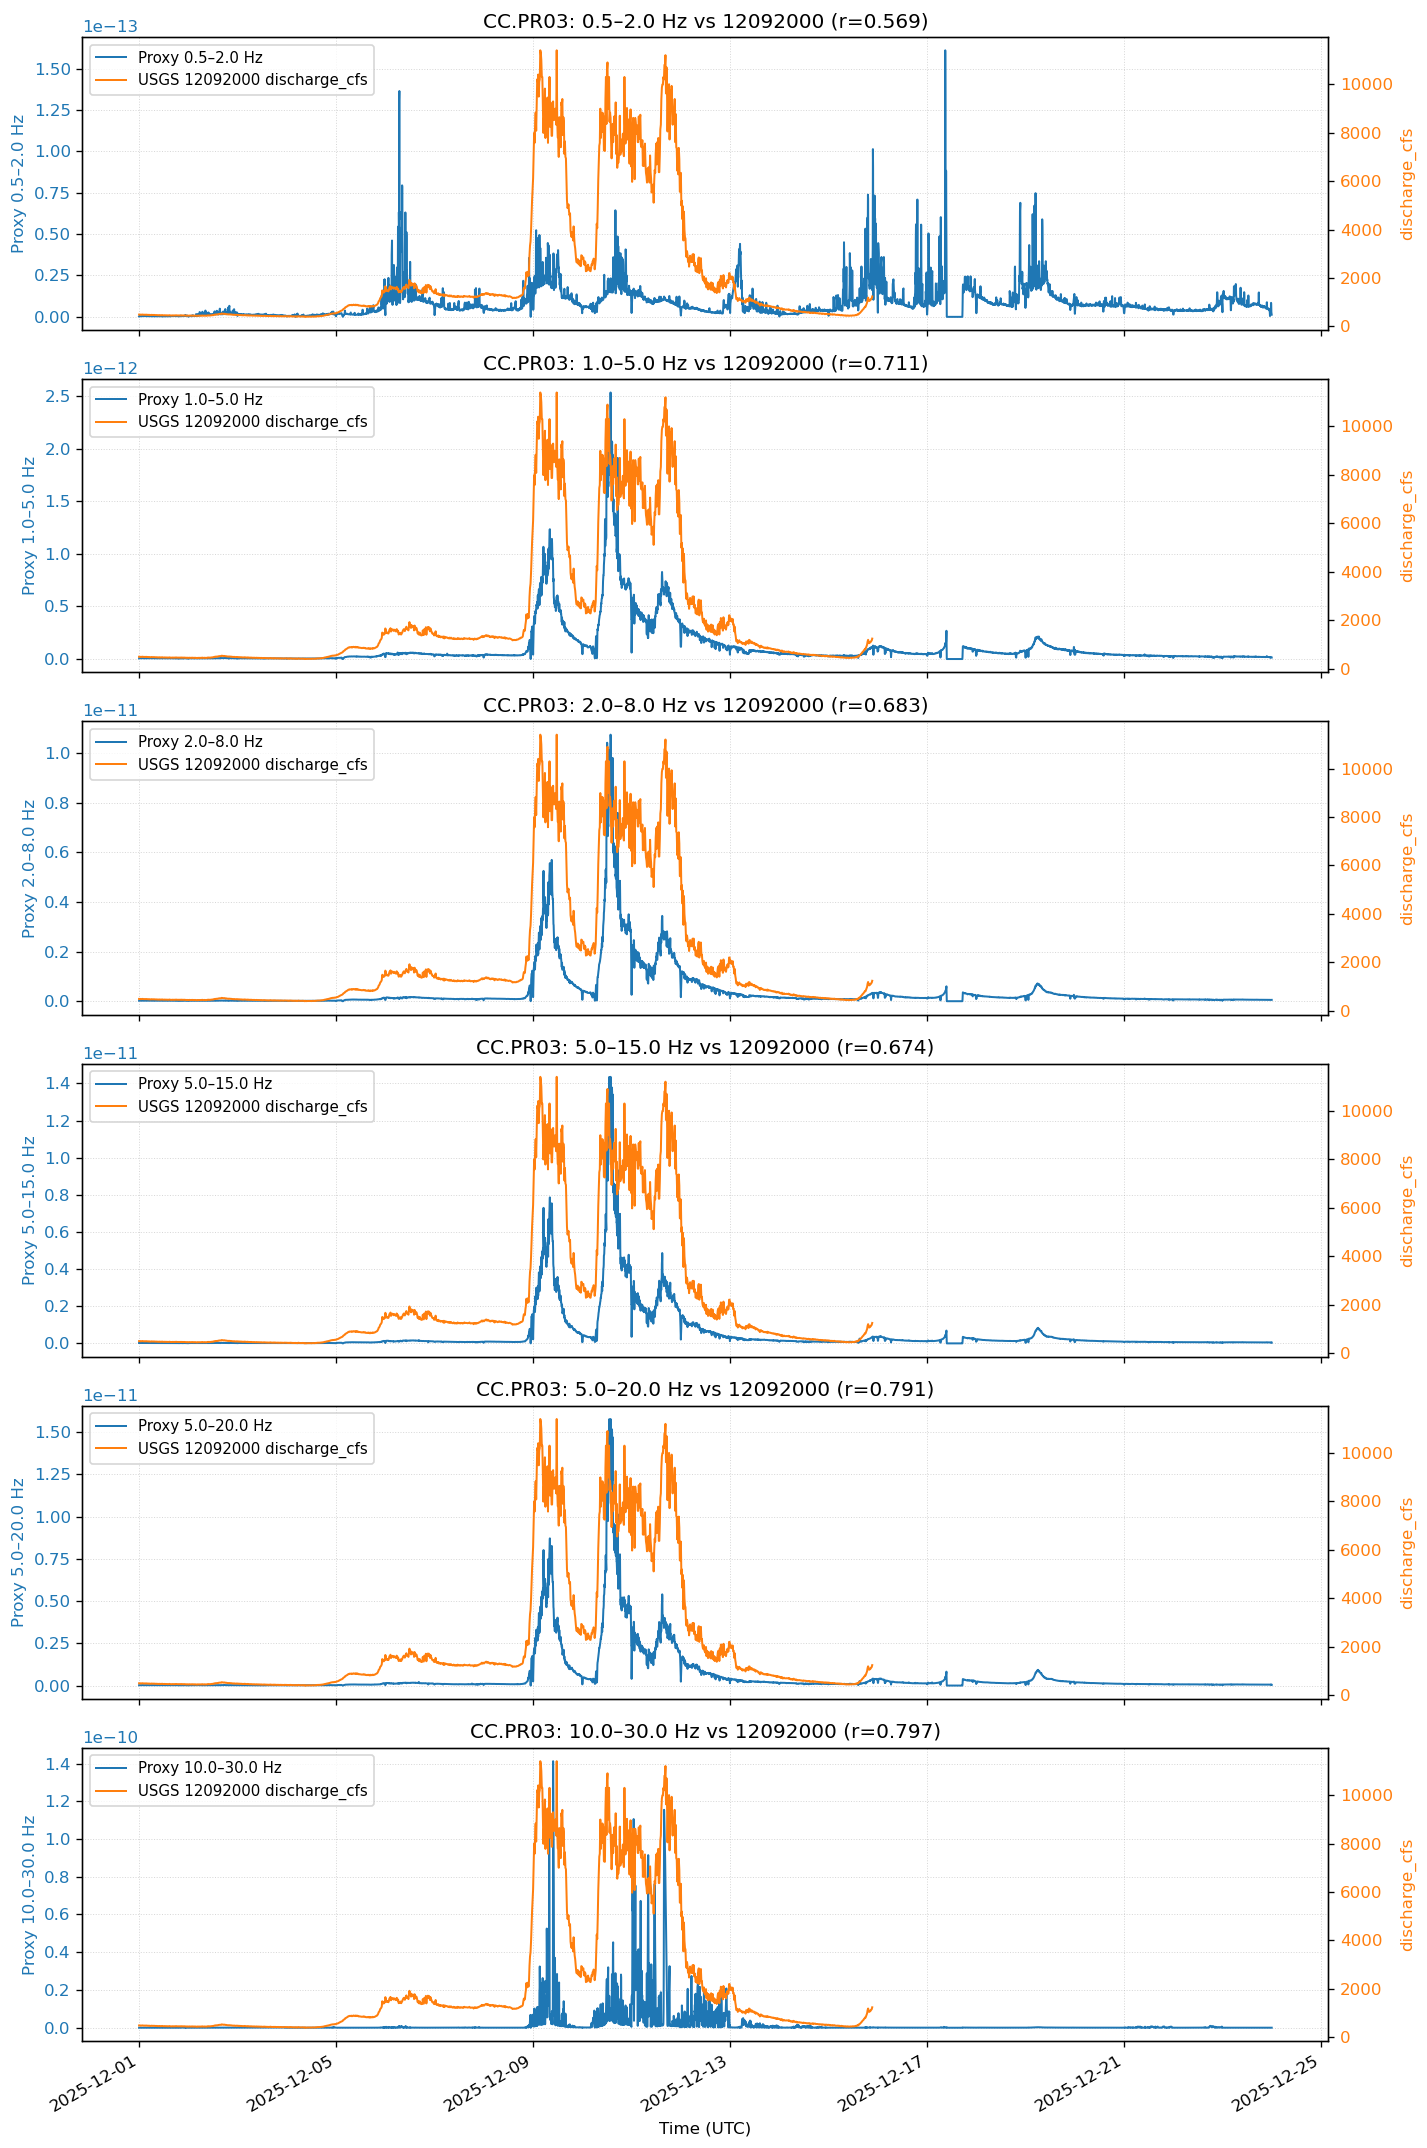

Best flow band (for lag selection): 2.0–8.0 Hz
Chosen constant lag: 0.83 hours


In [17]:
# --- Plot all band proxy series against discharge to compare before selecting best match ---
import matplotlib.pyplot as plt

sta_key = FOCUS_SEIS_KEY or (SEIS_KEYS[0] if len(SEIS_KEYS) else None)
if sta_key is None:
    raise RuntimeError("No stations in SEIS_KEYS")
if "band_proxies" not in globals() or not band_proxies or sta_key not in band_proxies:
    raise RuntimeError(f"band_proxies not available for {sta_key}. Run the band proxy computation cell first.")

gid = PAIRINGS.get(sta_key)
if gid is None or gid not in gauges:
    raise KeyError(f"No gauge found for {sta_key}")

g = gauges[gid].copy().sort_index()
sta_bands = band_proxies[sta_key]
bands = FLOW_BANDS + BEDLOAD_BANDS

fig, axes = plt.subplots(len(bands), 1, figsize=(12, 3 * len(bands)), sharex=True)
if len(bands) == 1:
    axes = [axes]

col = "discharge_cfs" if "discharge_cfs" in g.columns else "gage_height_ft"
gg_raw = g[[col]].dropna().sort_index()

for idx, (f1, f2) in enumerate(bands):
    band = (float(f1), float(f2))
    ax1 = axes[idx]

    if band not in sta_bands:
        ax1.set_title(f"{sta_key}: missing band {band[0]}–{band[1]} Hz")
        continue

    p_band = pd.Series(sta_bands[band]).dropna().sort_index()
    ax1.plot(p_band.index, p_band.values, lw=1.2, color="tab:blue", label=f"Proxy {band[0]}–{band[1]} Hz")
    ax1.set_ylabel(f"Proxy {band[0]}–{band[1]} Hz", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax1.grid(True, which="both", linestyle=":", linewidth=0.6, alpha=0.5)

    ax2 = ax1.twinx()
    ax2.plot(gg_raw.index, gg_raw[col], lw=1.2, color="tab:orange", label=f"USGS {gid} {col}")
    ax2.set_ylabel(col, color="tab:orange")
    ax2.tick_params(axis="y", labelcolor="tab:orange")

    corr_val = band_score[band_score["band"] == f"{band[0]}-{band[1]}"]["corr_log10"].values
    corr_str = f"(r={corr_val[0]:.3f})" if len(corr_val) > 0 else ""
    ax1.set_title(f"{sta_key}: {band[0]}–{band[1]} Hz vs {gid} {corr_str}")

    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left", fontsize=9)

axes[-1].set_xlabel("Time (UTC)")
plt.setp(axes[-1].get_xticklabels(), rotation=30, ha="right")
plt.tight_layout()

out_png = FIG_DIR / f"{sta_key}_bands_vs_{gid}.png"
fig.savefig(out_png, dpi=200, bbox_inches="tight")
print(f"Saved {out_png}")
plt.show()

# Optional quick printout if BEST_* bands exist
if "BEST_FLOW_BAND" in globals():
    print(f"Best flow band (for lag selection): {BEST_FLOW_BAND[0]}–{BEST_FLOW_BAND[1]} Hz")
if "BEST_BED_BAND" in globals():
    print(f"Best bedload band (at fixed tau): {BEST_BED_BAND[0]}–{BEST_BED_BAND[1]} Hz")
if "BEST_TAU_S" in globals():
    print(f"Chosen constant lag: {BEST_TAU_S/3600:.2f} hours")


In [18]:
BEDLOAD_BANDS

[(5.0, 15.0), (5.0, 20.0), (10.0, 30.0)]

Best bedload band at fixed tau: 10.0–30.0 Hz (corr=0.797)
Thresholded analysis: keeping q >= 1290.00 (60% percentile), n=583/1430
Saved data/figures/CC.PR03_bedrock_diagnostics.png


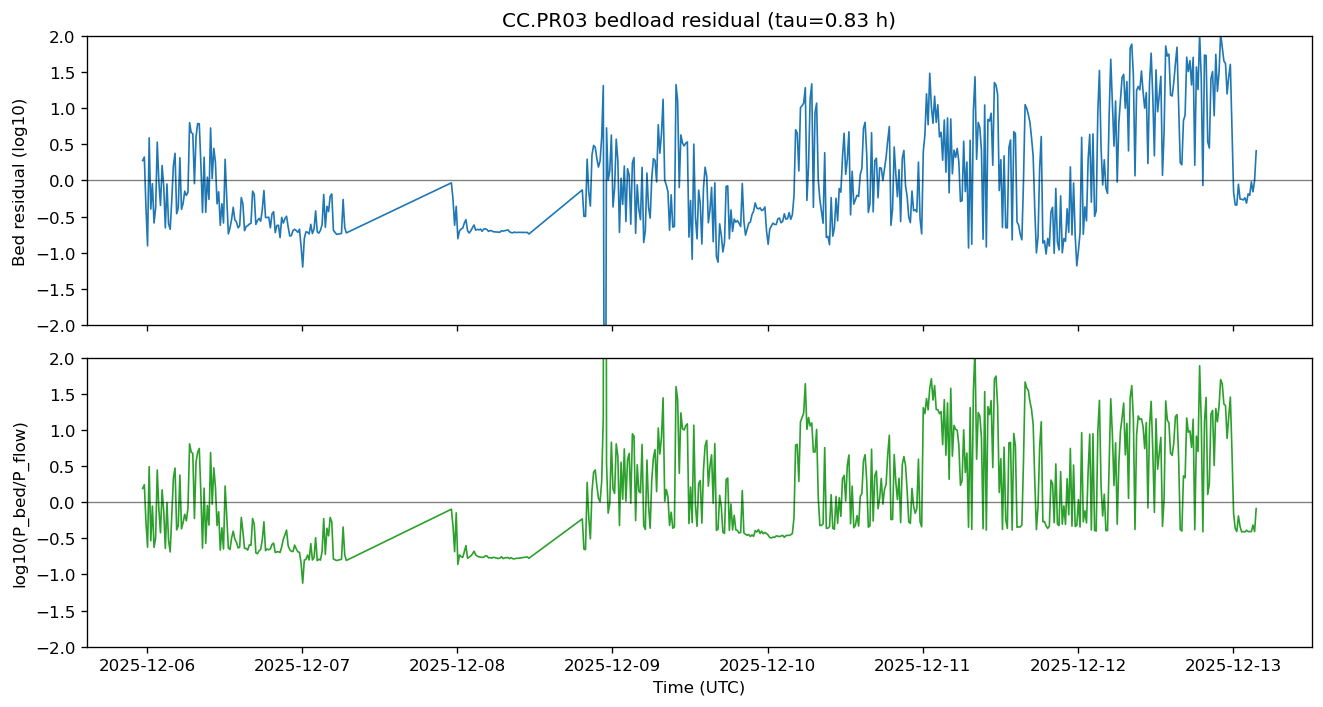

In [20]:
# --- Bedrock-river oriented diagnostics: threshold + residual/ratio (focused station) ---
import matplotlib.pyplot as plt

sta_key = FOCUS_SEIS_KEY or (SEIS_KEYS[0] if len(SEIS_KEYS) else None)
if sta_key is None:
    raise RuntimeError("No stations in SEIS_KEYS")
if "band_proxies" not in globals() or not band_proxies or sta_key not in band_proxies:
    raise RuntimeError(f"band_proxies not available for {sta_key}. Run the band proxy computation cell first.")

gid = PAIRINGS.get(sta_key)
if gid is None or gid not in gauges:
    raise KeyError(f"No gauge found for {sta_key}")

g = gauges[gid].copy().sort_index()
sta_bands = band_proxies[sta_key]

if "band_score" not in globals() or band_score is None or len(band_score) == 0:
    raise RuntimeError("band_score not available. Run the band exploration + lag selection cell first.")
if "BEST_TAU_S" not in globals() or BEST_TAU_S is None:
    raise RuntimeError("BEST_TAU_S not available. Run the band exploration + lag selection cell first.")
if "BEST_FLOW_BAND" not in globals() or BEST_FLOW_BAND is None:
    raise RuntimeError("BEST_FLOW_BAND not available. Run the band exploration + lag selection cell first.")

bed_scores = band_score[band_score["band"].isin([f"{b[0]}-{b[1]}" for b in BEDLOAD_BANDS])].copy()
if bed_scores.empty:
    raise RuntimeError("No BEDLOAD_BANDS found in band_score")
best_bed_row = bed_scores.iloc[0]
BEST_BED_BAND = (float(best_bed_row["fmin"]), float(best_bed_row["fmax"]))
print(
    f"Best bedload band at fixed tau: {BEST_BED_BAND[0]}–{BEST_BED_BAND[1]} Hz "
    f"(corr={best_bed_row['corr_log10']:.3f})"
)

p_flow = pd.Series(sta_bands[BEST_FLOW_BAND]).rename("p_flow")
p_bed = pd.Series(sta_bands[BEST_BED_BAND]).rename("p_bed")
col = "discharge_cfs" if "discharge_cfs" in g.columns else "gage_height_ft"

gg = g[[col]].dropna().sort_index().copy()
gg.index = gg.index + pd.Timedelta(seconds=float(BEST_TAU_S))
gg = gg[col].rename("q")

df = pd.concat([p_flow, p_bed, gg], axis=1).dropna()
if len(df) < 30:
    raise RuntimeError("Not enough overlapping samples after applying tau")

tiny = np.finfo(float).tiny
df["log_flow"] = np.log10(df["p_flow"].clip(lower=tiny))
df["log_bed"] = np.log10(df["p_bed"].clip(lower=tiny))
df["log_q"] = np.log10(df["q"].clip(lower=tiny))

Q_THRESH_PCT = 0.60
q_thr = float(df["q"].quantile(Q_THRESH_PCT))
df_hi = df[df["q"] >= q_thr].copy()
print(f"Thresholded analysis: keeping q >= {q_thr:.2f} ({Q_THRESH_PCT:.0%} percentile), n={len(df_hi)}/{len(df)}")

m, b = np.polyfit(df_hi["log_q"].values, df_hi["log_bed"].values, 1)
df_hi["bed_resid"] = df_hi["log_bed"] - (m * df_hi["log_q"] + b)
df_hi["ratio_bed_flow"] = df_hi["log_bed"] - df_hi["log_flow"]

fig, ax = plt.subplots(2, 1, figsize=(11, 6), sharex=True)
ax[0].plot(df_hi.index, df_hi["bed_resid"], lw=1.0)
ax[0].axhline(0, color="k", lw=0.8, alpha=0.5)
ax[0].set_ylabel("Bed residual (log10)")
ax[0].set_ylim([-2, 2])
ax[0].set_title(f"{sta_key} bedload residual (tau={BEST_TAU_S/3600:.2f} h)")

ax[1].plot(df_hi.index, df_hi["ratio_bed_flow"], lw=1.0, color="tab:green")
ax[1].axhline(0, color="k", lw=0.8, alpha=0.5)
ax[1].set_ylabel("log10(P_bed/P_flow)")
ax[1].set_xlabel("Time (UTC)")
ax[1].set_ylim([-2, 2])
plt.tight_layout()

out_png = FIG_DIR / f"{sta_key}_bedrock_diagnostics.png"
fig.savefig(out_png, dpi=200, bbox_inches="tight")
print(f"Saved {out_png}")
plt.show()


In [21]:
df.head()

,p_flow,p_bed,q,log_flow,log_bed,log_q
time_utc,,,,,,
2025-12-01 00:50:00+00:00,2.163151e-14,7.362256e-15,491.0,-13.664913,-14.132989,2.691081
2025-12-01 01:05:00+00:00,2.235344e-14,8.830249e-15,491.0,-13.650656,-14.054027,2.691081
2025-12-01 01:20:00+00:00,2.137167e-14,7.059006e-15,491.0,-13.670162,-14.151256,2.691081
2025-12-01 01:35:00+00:00,2.184970e-14,7.426489e-15,480.0,-13.660555,-14.129216,2.681241
2025-12-01 01:50:00+00:00,2.505957e-14,7.184863e-15,485.0,-13.601026,-14.143582,2.685742


In [22]:
# --- Export fitted parameters + aligned time series (band-only) ---
from pathlib import Path

RESULTS_DIR = DATA_DIR / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)


def _pick_gauge_col(gauge_df: pd.DataFrame) -> str:
    if "discharge_cfs" in gauge_df.columns:
        return "discharge_cfs"
    if "gage_height_ft" in gauge_df.columns:
        return "gage_height_ft"
    raise KeyError("Gauge dataframe missing discharge_cfs and gage_height_ft")


def _fit_loglog_powerlaw(proxy_s: pd.Series, gauge_df: pd.DataFrame, *, tau_s: float, gauge_col: str, min_pairs: int = 30) -> dict:
    # Fit log10(P) = a + beta log10(Q) after shifting gauge by tau_s.
    p = proxy_s.dropna().sort_index()
    g = gauge_df[[gauge_col]].dropna().sort_index().copy()
    g.index = g.index + pd.Timedelta(seconds=float(tau_s))
    joined = pd.concat([p.rename("P"), g[gauge_col].rename("Q")], axis=1).dropna()
    n_pairs = int(len(joined))
    if n_pairs < min_pairs:
        return {"n_pairs": n_pairs, "corr_log10": float("nan"), "beta": float("nan"), "a": float("nan")}
    tiny = np.finfo(float).tiny
    x = np.log10(joined["Q"].clip(lower=tiny).astype(float).values)
    y = np.log10(joined["P"].clip(lower=tiny).astype(float).values)
    beta, a = np.polyfit(x, y, 1)
    corr = float(pd.Series(x).corr(pd.Series(y)))
    return {"n_pairs": n_pairs, "corr_log10": corr, "beta": float(beta), "a": float(a)}


def _build_aligned_timeseries(proxy_s: pd.Series, gauge_df: pd.DataFrame, *, tau_s: float, gauge_col: str) -> pd.DataFrame:
    p = proxy_s.rename("proxy").sort_index()
    g_raw = gauge_df[[gauge_col]].rename(columns={gauge_col: "gauge"}).sort_index()
    g_shift = g_raw.copy()
    g_shift.index = g_shift.index + pd.Timedelta(seconds=float(tau_s))
    g_shift = g_shift.rename(columns={"gauge": "gauge_shifted"})
    return pd.concat([p, g_raw, g_shift], axis=1).sort_index()


def _corr_at_tau(proxy_s: pd.Series, gauge_df: pd.DataFrame, *, tau_s: float, gauge_col: str, min_pairs: int = 30) -> float:
    p = proxy_s.dropna().sort_index()
    g = gauge_df[[gauge_col]].dropna().sort_index().copy()
    g.index = g.index + pd.Timedelta(seconds=float(tau_s))
    joined = pd.concat([p.rename("P"), g[gauge_col].rename("Q")], axis=1).dropna()
    if len(joined) < min_pairs:
        return float("nan")
    tiny = np.finfo(float).tiny
    x = np.log10(joined["Q"].clip(lower=tiny).astype(float))
    y = np.log10(joined["P"].clip(lower=tiny).astype(float))
    return float(x.corr(y))


if "band_proxies" not in globals() or not band_proxies:
    raise RuntimeError("band_proxies is missing/empty. Run the band proxy computation cell(s) first.")

rows = []

for sta_key, sta_bands in band_proxies.items():
    gid = PAIRINGS.get(sta_key)
    if gid is None or gid not in gauges:
        continue

    gauge_df = gauges[gid]
    gauge_col = _pick_gauge_col(gauge_df)

    # Choose tau per station using the best FLOW band
    best_tau_s = None
    best_flow_band = None
    best_peak = -float("inf")
    for band in FLOW_BANDS:
        band = (float(band[0]), float(band[1]))
        if band not in sta_bands:
            continue
        tau_s, tbl = estimate_constant_lag_seconds(
            sta_bands[band],
            gauge_df,
            gauge_col=gauge_col,
            max_lag_hours=LAG_MAX_HOURS,
            step_minutes=LAG_STEP_MINUTES,
            min_pairs=30,
        )
        peak = float(tbl["corr"].max(skipna=True))
        if peak == peak and peak > best_peak:
            best_peak = peak
            best_tau_s = float(tau_s)
            best_flow_band = band

    if best_tau_s is None or best_flow_band is None:
        continue

    # Choose a representative BEDLOAD band at fixed tau
    best_bed_band = None
    best_bed_corr = -float("inf")
    for band in BEDLOAD_BANDS:
        band = (float(band[0]), float(band[1]))
        if band not in sta_bands:
            continue
        r = _corr_at_tau(sta_bands[band], gauge_df, tau_s=best_tau_s, gauge_col=gauge_col)
        if r == r and r > best_bed_corr:
            best_bed_corr = r
            best_bed_band = band

    export_bands = [best_flow_band]
    if best_bed_band is not None and best_bed_band != best_flow_band:
        export_bands.append(best_bed_band)

    for band in export_bands:
        proxy_s = sta_bands[band]
        fit = _fit_loglog_powerlaw(proxy_s, gauge_df, tau_s=best_tau_s, gauge_col=gauge_col, min_pairs=30)
        ts = _build_aligned_timeseries(proxy_s, gauge_df, tau_s=best_tau_s, gauge_col=gauge_col)

        ts_out = RESULTS_DIR / f"{sta_key}_{band[0]}-{band[1]}Hz_timeseries.csv"
        ts.to_csv(ts_out)

        meta = STATION_META.get(sta_key, {})
        rows.append(
            {
                "seis_key": sta_key,
                "network": meta.get("network", sta_key.split(".", 1)[0]),
                "station": meta.get("station", sta_key.split(".", 1)[1] if "." in sta_key else sta_key),
                "gage_id": gid,
                "gage_distance_km": meta.get("gage_distance_km"),
                "proxy_method": PROXY_METHOD,
                "use_rss": bool(USE_RSS),
                "components": ",".join(COMPONENTS),
                "band_fmin": float(band[0]),
                "band_fmax": float(band[1]),
                "tau_s": float(best_tau_s),
                "tau_hours": float(best_tau_s) / 3600.0,
                "gauge_col": gauge_col,
                "n_pairs": fit["n_pairs"],
                "corr_log10": fit["corr_log10"],
                "beta": fit["beta"],
                "a": fit["a"],
                "timeseries_csv": ts_out.name,
            }
        )

fit_parameters = pd.DataFrame(rows).sort_values(["seis_key", "band_fmin", "band_fmax"]).reset_index(drop=True)
display(fit_parameters)

params_csv = RESULTS_DIR / "fit_parameters.csv"
fit_parameters.to_csv(params_csv, index=False)
print(f"Saved {params_csv}")


,seis_key,network,station,gage_id,gage_distance_km,proxy_method,use_rss,components,band_fmin,band_fmax,tau_s,tau_hours,gauge_col,n_pairs,corr_log10,beta,a,timeseries_csv
0,CC.PR03,CC,PR03,12092000,0.186398,bandpower,True,"Z,N,E",2.0,8.0,3000.0,0.833333,discharge_cfs,1430,0.683297,1.547315,-17.685307,CC.PR03_2.0-8.0Hz_timeseries.csv
1,CC.PR03,CC,PR03,12092000,0.186398,bandpower,True,"Z,N,E",10.0,30.0,3000.0,0.833333,discharge_cfs,1430,0.796943,2.054419,-19.314354,CC.PR03_10.0-30.0Hz_timeseries.csv


Saved data/results/fit_parameters.csv


## 4) Plotting and diagnostics

We provide:
- time-series overlay (proxy vs stage)
- hysteresis scatter plot (proxy vs stage)
- optional frequency-band sweep to test sensitivity


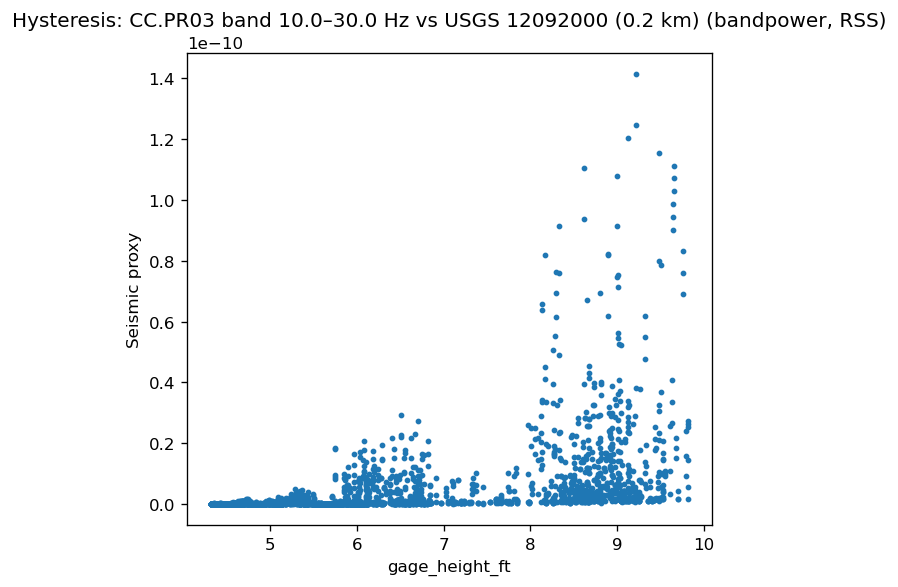

In [23]:
# --- Hysteresis (proxy vs gage) for the focused station (band-only) ---
sta_key = FOCUS_SEIS_KEY or (SEIS_KEYS[0] if len(SEIS_KEYS) else None)
if sta_key is None:
    raise RuntimeError("No stations in SEIS_KEYS")

gid = PAIRINGS.get(sta_key)
if gid is None or gid not in gauges:
    raise KeyError(f"No gauge found for {sta_key}")

if "band_proxies" not in globals() or not band_proxies or sta_key not in band_proxies:
    raise RuntimeError(f"band_proxies not available for {sta_key}. Run the band proxy computation cell first.")

sta_bands = band_proxies[sta_key]

preferred = []
for nm in ("BEST_BED_BAND", "BEST_FLOW_BAND"):
    b = globals().get(nm)
    if b:
        preferred.append(b)
preferred.extend(list(sta_bands.keys()))

band = next((b for b in preferred if b in sta_bands), None)
if band is None:
    raise RuntimeError(f"No band proxy series available for {sta_key}")

dist_km = STATION_META.get(sta_key, {}).get("gage_distance_km")
dist_str = f" ({dist_km:.1f} km)" if dist_km is not None else ""
rss_str = "RSS" if USE_RSS else "Z"

title = f"Hysteresis: {sta_key} band {band[0]}–{band[1]} Hz vs USGS {gid}{dist_str} ({PROXY_METHOD}, {rss_str})"

hysteresis_plot(
    sta_bands[band],
    gauges[gid],
    title=title,
    save_dir=FIG_DIR,
    filename=f"{sta_key}_{band[0]}-{band[1]}Hz_hysteresis_vs_{gid}_section4.png",
)


Saved figures/CC.PR03_hysteresis_bed_bands_vs_12092000_subplots_tight_colorbar_outside_with_fits.png


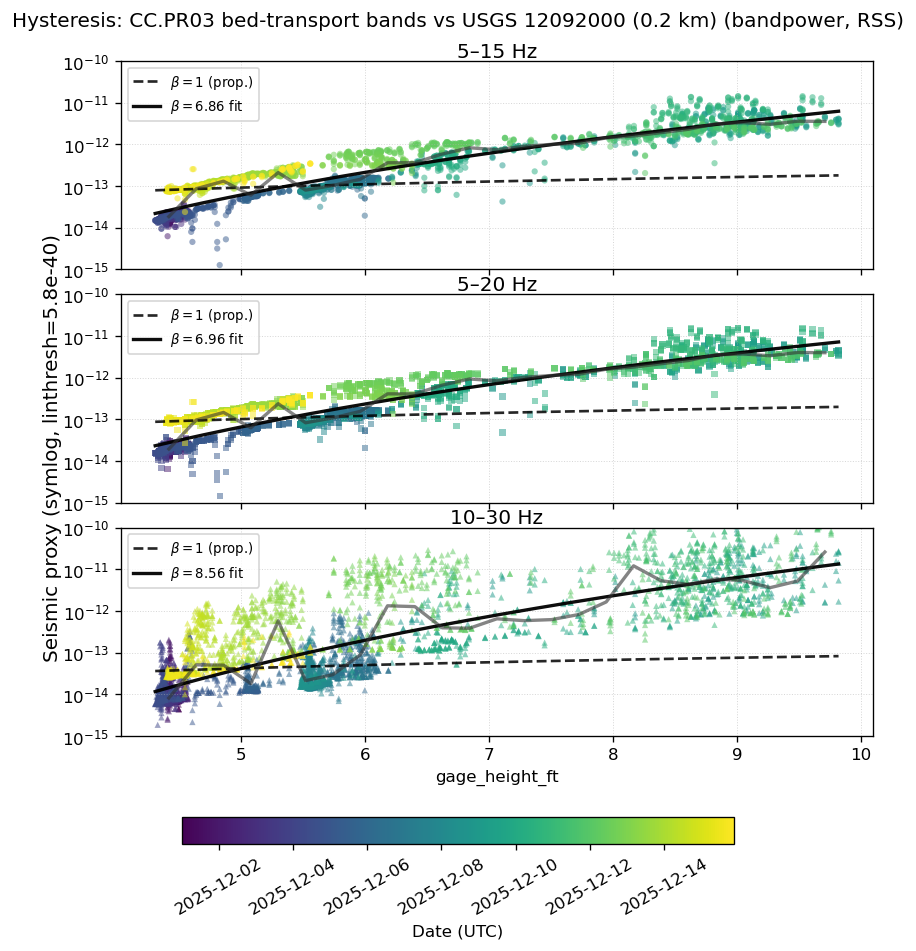

In [39]:
# --- Combined hysteresis for all bed-transport (BEDLOAD) bands ---
# One subplot per frequency band; color encodes date/time (UTC).
# Also overlays two simple fits (per band):
#   1) proportionality (fixed exponent beta=1 in log-log space)
#   2) best-fit power law exponent beta from log-log regression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors

sta_key = FOCUS_SEIS_KEY or (SEIS_KEYS[0] if len(SEIS_KEYS) else None)
if sta_key is None:
    raise RuntimeError("No stations in SEIS_KEYS")

gid = PAIRINGS.get(sta_key)
if gid is None or gid not in gauges:
    raise KeyError(f"No gauge found for {sta_key}")

if "band_proxies" not in globals() or not isinstance(band_proxies, dict) or len(band_proxies) == 0:
    raise RuntimeError("band_proxies is not available. Run the band proxy computation cell(s) in Section 3 first.")
if sta_key not in band_proxies:
    raise KeyError(f"No band proxy series found for {sta_key}")

sta_bands = band_proxies[sta_key]
g = gauges[gid].copy().sort_index()

stage_col = (
    "gage_height_ft" if "gage_height_ft" in g.columns else ("discharge_cfs" if "discharge_cfs" in g.columns else None)
 )
if stage_col is None:
    raise KeyError("Gauge dataframe missing gage_height_ft and discharge_cfs")

dist_km = STATION_META.get(sta_key, {}).get("gage_distance_km")
dist_str = f" ({dist_km:.1f} km)" if dist_km is not None else ""
rss_str = "RSS" if USE_RSS else "Z"
tolerance = "10min"

USE_SYMLOG_Y = True
N_BINS = 25
SHOW_BINNED_MEDIAN = True
MIN_FIT_PAIRS = 50

markers = ["o", "s", "^", "D", "P", "X", "v", ">", "<", "*"]
cmap = plt.get_cmap("viridis")

# Determine symlog threshold from smallest positive proxy across bands
min_pos = np.inf
for (f1, f2) in BEDLOAD_BANDS:
    band = (float(f1), float(f2))
    if band not in sta_bands:
        continue
    p = pd.Series(sta_bands[band]).dropna().astype(float)
    ppos = p[p > 0]
    if not ppos.empty:
        min_pos = min(min_pos, float(ppos.min()))
linthresh = (10.0 * min_pos) if np.isfinite(min_pos) else 1e-12

# Bin edges for optional binned medians (shared across subplots)
x_all = g[stage_col].dropna().astype(float)
bin_edges = np.linspace(float(x_all.min()), float(x_all.max()), N_BINS + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# First pass: compute global time range across all plotted points for a consistent color scale
tmin = np.inf
tmax = -np.inf
for (f1, f2) in BEDLOAD_BANDS:
    band = (float(f1), float(f2))
    if band not in sta_bands:
        continue
    p = pd.Series(sta_bands[band]).dropna().sort_index().astype(float)
    if p.empty:
        continue
    df = pd.DataFrame({"proxy": p})
    df[stage_col] = g[stage_col].reindex(df.index, method="nearest", tolerance=pd.Timedelta(tolerance))
    df = df.dropna()
    if df.empty:
        continue
    t = mdates.date2num(df.index.to_pydatetime())
    tmin = min(tmin, float(np.nanmin(t)))
    tmax = max(tmax, float(np.nanmax(t)))
norm = mcolors.Normalize(vmin=tmin if np.isfinite(tmin) else None, vmax=tmax if np.isfinite(tmax) else None)

# Subplots: one per frequency band
n_bands = len(BEDLOAD_BANDS)
fig, axes = plt.subplots(
    n_bands,
    1,
    figsize=(7.2, 2.5 * n_bands),
    sharex=True,
    sharey=True,
    constrained_layout=False,
 )
if n_bands == 1:
    axes = [axes]

for i, (f1, f2) in enumerate(BEDLOAD_BANDS):
    ax = axes[i]
    band = (float(f1), float(f2))
    if band not in sta_bands:
        ax.set_title(f"Missing band {band[0]}–{band[1]} Hz", pad=2)
        ax.axis("off")
        continue

    p = pd.Series(sta_bands[band]).dropna().sort_index().astype(float)
    df = pd.DataFrame({"proxy": p})
    df[stage_col] = g[stage_col].reindex(df.index, method="nearest", tolerance=pd.Timedelta(tolerance))
    df = df.dropna()
    if df.empty:
        ax.set_title(f"{band[0]:g}–{band[1]:g} Hz (no overlap)", pad=2)
        ax.axis("off")
        continue

    marker = markers[i % len(markers)]
    t = mdates.date2num(df.index.to_pydatetime())

    x = df[stage_col].values.astype(float)
    y = df["proxy"].values.astype(float)

    ax.scatter(
        x,
        y,
        s=14,
        alpha=0.5,
        c=t,
        cmap=cmap,
        norm=norm,
        marker=marker,
        edgecolors="none",
        rasterized=True,
    )

    # Fits in log-log space (only when x>0 and y>0)
    mask = np.isfinite(x) & np.isfinite(y) & (x > 0) & (y > 0)
    if int(mask.sum()) >= int(MIN_FIT_PAIRS):
        xlog = np.log10(x[mask])
        ylog = np.log10(y[mask])

        # 1) "proportionality" (fixed slope beta=1): choose intercept robustly
        a_prop = float(np.nanmedian(ylog - xlog))
        beta_prop = 1.0

        # 2) best-fit power law exponent beta via linear regression on logs
        beta_fit, a_fit = np.polyfit(xlog, ylog, 1)
        beta_fit = float(beta_fit)
        a_fit = float(a_fit)

        xgrid = np.linspace(float(np.nanmin(x[mask])), float(np.nanmax(x[mask])), 200)
        y_prop = (10.0 ** a_prop) * (xgrid ** beta_prop)
        y_fit = (10.0 ** a_fit) * (xgrid ** beta_fit)

        ax.plot(xgrid, y_prop, color="k", lw=1.6, alpha=0.85, linestyle="--", label=r"$\beta=1$ (prop.)")
        ax.plot(xgrid, y_fit, color="k", lw=2.0, alpha=0.95, linestyle="-", label=rf"$\beta={beta_fit:.2f}$ fit")
        ax.legend(loc="upper left", fontsize=8, frameon=True)

    if SHOW_BINNED_MEDIAN:
        bin_idx = np.digitize(x, bin_edges) - 1
        med = np.full(N_BINS, np.nan, dtype=float)
        for b in range(N_BINS):
            yy = y[bin_idx == b]
            if yy.size >= 10:
                med[b] = np.nanmedian(yy)
        ax.plot(bin_centers, med, color="0.2", lw=2.0, alpha=0.6)

    if USE_SYMLOG_Y:
        ax.set_yscale("symlog", linthresh=linthresh)
    ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.5)
    ax.set_title(f"{band[0]:g}–{band[1]:g} Hz", pad=2)

axes[-1].set_xlabel(stage_col)
fig.supylabel(f"Seismic proxy (symlog, linthresh={linthresh:.2g})" if USE_SYMLOG_Y else "Seismic proxy")
fig.suptitle(f"Hysteresis: {sta_key} bed-transport bands vs USGS {gid}{dist_str} ({PROXY_METHOD}, {rss_str})", y=0.985)

# Shared horizontal colorbar OUTSIDE the subplot grid (dedicated axes below)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

# Reserve bottom margin for the colorbar so it never overprints the subplots/xlabel
fig.subplots_adjust(top=0.93, bottom=0.18, left=0.11, right=0.98, hspace=0.12)

# Add a new axes for the colorbar in figure coordinates: [left, bottom, width, height]
cax = fig.add_axes([0.18, 0.06, 0.64, 0.03])
cbar = fig.colorbar(sm, cax=cax, orientation="horizontal")
cbar.set_label("Date (UTC)")
cbar.ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
cbar.ax.tick_params(axis="x", rotation=30)

# Keep previous y-limits (adjust if you prefer autoscaling)
for ax in axes:
    ax.set_ylim(10**-15, 10**-10)

out_png = FIG_DIR / f"{sta_key}_hysteresis_bed_bands_vs_{gid}_subplots_tight_colorbar_outside_with_fits.png"
fig.savefig(out_png, dpi=250, bbox_inches="tight")
print(f"Saved {out_png}")
plt.show()


### Run comparisons for your station↔gauge pairings


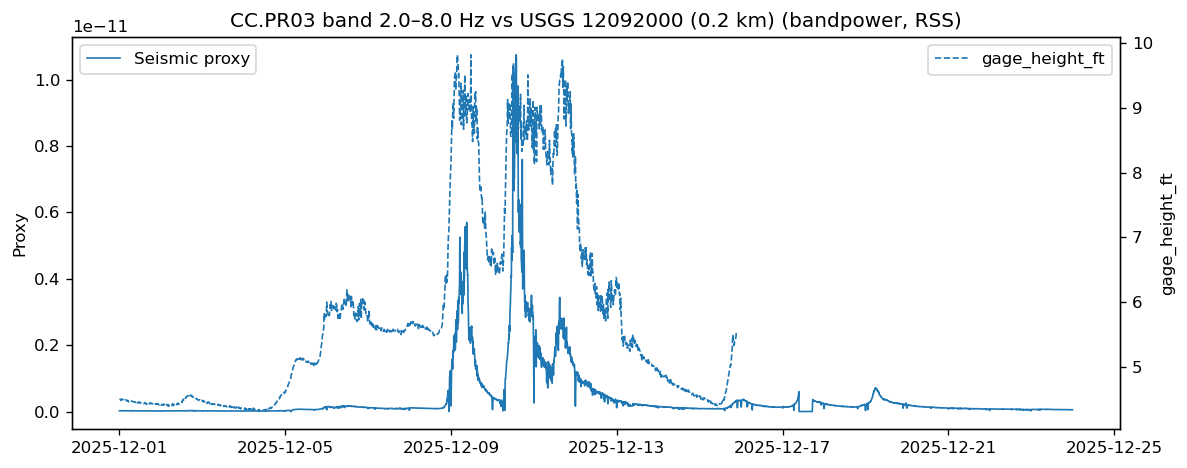

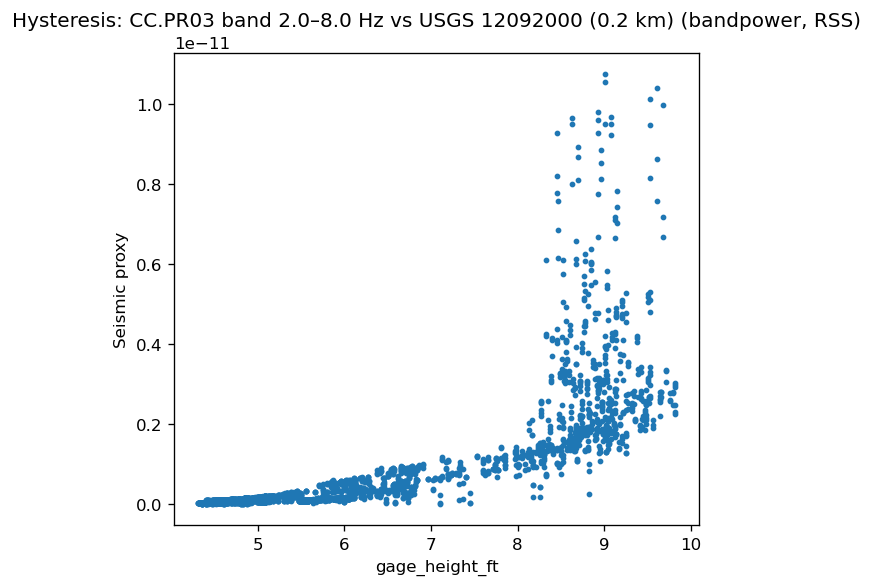

In [26]:
# Run comparisons for station↔gage pairings derived from metadata (band-only)
rss_str = "RSS" if USE_RSS else "Z"

if "band_proxies" not in globals() or not band_proxies:
    raise RuntimeError("band_proxies is missing/empty. Run the band proxy computation cell(s) first.")

for sta_key, gid in PAIRINGS.items():
    if sta_key not in band_proxies:
        print(f"Skipping {sta_key} ↔ {gid} (missing band series)")
        continue
    if gid not in gauges:
        print(f"Skipping {sta_key} ↔ {gid} (missing gauge data)")
        continue

    dist_km = STATION_META.get(sta_key, {}).get("gage_distance_km")
    dist_str = f" ({dist_km:.1f} km)" if dist_km is not None else ""

    sta_bands = band_proxies[sta_key]
    preferred = []
    for nm in ("BEST_FLOW_BAND", "BEST_BED_BAND"):
        b = globals().get(nm)
        if b:
            preferred.append(b)
    preferred.extend(list(sta_bands.keys()))

    band = next((b for b in preferred if b in sta_bands), None)
    if band is None:
        print(f"Skipping {sta_key} ↔ {gid} (no bands available)")
        continue

    proxy_s = sta_bands[band]
    title = f"{sta_key} band {band[0]}–{band[1]} Hz vs USGS {gid}{dist_str} ({PROXY_METHOD}, {rss_str})"

    plot_proxy_and_gauge(
        proxy_s,
        gauges[gid],
        title=title,
        save_dir=FIG_DIR,
        filename=f"{sta_key}_{band[0]}-{band[1]}Hz_proxy_vs_{gid}_summary.png",
    )
    hysteresis_plot(
        proxy_s,
        gauges[gid],
        title=f"Hysteresis: {title}",
        save_dir=FIG_DIR,
        filename=f"{sta_key}_{band[0]}-{band[1]}Hz_hysteresis_vs_{gid}.png",
    )


## 5) Next steps (toward sediment flux)

If you see a robust storm-correlated seismic band and **lag/hysteresis** relative to stage/discharge, the next upgrades are:

1. Replace RMS with **Welch PSD band power** per window.
2. Add a **coherence check** vs a reference station far from rivers (to suppress cultural noise).
3. Calibrate against any independent sediment proxy (geophones, turbidity/SSC, event yields).
4. Implement a **physics-based model/inversion** (Gimbert-style) if you have grain-size distributions and geometry.

If you want, paste the channel IDs printed above (or station metadata), and we can tighten channel selection (e.g., vertical-only vs RSS, exact HN? codes per site).
